<a href="https://colab.research.google.com/github/camilo-nunez/INF395-T1/blob/master/201573598_201573573_taller_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF-395/477 Redes Neuronales Artificiales I-2020 </h1>
    <h3> Tarea 1 - Redes Neuronales y *Deep Learning* </h3>
</center>

Nombres: Leonardo Astudillo Villalon  & Camilo Nunez Fernandez

Roles: 201573598-0 &201573573-5

Correos:
leonardo.astudillov@sansano.usm.cl & camilo.nunezf@sansano.usm.cl
<hr style="height:2px;border:none"/>


**Temas**  

* Arquitectura Básica de Redes Neuronales. Redes *Feed-Forward*
* Entrenamiento de Redes Neuronales. 
* Redes Convolucionales. 

<hr style="height:2px;border:none"/>

# Variables generales y de entorno

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')

In [0]:
! mkdir data_in

In [0]:
! pip install -q kaggle

In [0]:
! mkdir ~/.kaggle
! touch ~/.kaggle/kaggle.json
! echo '{"username":"camilonunez","key":"2a3f10da1c6cb2fce035cdf7b7aa2198"}' > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
! rm -rf data_in/*

# Métricas utilizadas

Las métricas de rendimiento que se utilizan para esta parte son precisión, recall y F1 score. Para todas estas métricas un valor cercano a 1 representa un buen rendimiento del modelo.

Para definir estas metricas, primero definimos los siguientes términos:

datos verdaderos positivos (TP): Valores los cuales el modelo asignó a la categoría a evaluar y el valor pertenece a esa categoria.
datos falsos positivos (FP): Valores los cuales el modelo asignó a la categoría a evaluar y el valor no pertenece a esa categoria.
datos falsos negativos (FN): Valores los cuales el modelo no asignó a la categoría a evaluar y el valor pertenece a esa categoria.

Formulas para las Métricas de Rendimiento:

$$
\begin{align*} 
\text{Precision} &= \frac{TP}{TP + FP}\\
\text{Recall} &= \frac{TP}{TP + FN}\\
\text{F1 Score} &= 2 * \frac{(precision * recall)}{(precision * recall)}
\end{align*}
$$

In [6]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


El código para obtener `F1` fue sacado del siguiten issue https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

# Pregunta Libre

Refute o evidencie experimentalmente una de las siguientes afirmaciones 

> **Limitaciones de una NN**: El desbalanceo de las clases no tiene ningún efecto en el entrenamiento de la red.


## Desarrollo

El desarrollo de esta tarea consiste en analizar redes neuronales con datasets categoricos y evaluar si es que el desbalanceo de clases, es decir, que una clase o varias clases tengan una menor cantidad de datos supervisados en comparación a las otras clases. 

Para el analisis, tomamos 2 datasets reales y 1 sintetico:


*   Fashionmnist (Real)
*   Digit-Recognizer (Real)
*   `sklearn.datasets.make_classification` (Sintético)


Luego se hicieron pruebas con redes neuronales ya definidas en competencias o en issues, con dataset de clases equilibradas. A partir de estos dataset, se realizaron reducciones $50\%$ y $90\%$ de algunas clases asociadas a los dataset.

### Dataset real - Fashionmnist


Fashion-MNIST es un dataset proveniente de la plataforma Zalando que consiste en imagenes de ropa de 28x28  en escala de grises, que tienen asociados una etiqueta de 10 clases de ropa.

La red esta basada en el siguiente articulo:
https://www.kaggle.com/fuzzywizard/fashion-mnist-cnn-keras-accuracy-93


#### Dataset normal

Extracción del dataset en kaggle

In [7]:
! mkdir data_in/fashionmnist
! kaggle datasets download zalando-research/fashionmnist -p data_in/fashionmnist
! unzip data_in/fashionmnist/fashionmnist.zip -d data_in/fashionmnist

 95% 65.0M/68.8M [00:00<00:00, 49.3MB/s]
100% 68.8M/68.8M [00:00<00:00, 83.3MB/s]
Archive:  data_in/fashionmnist/fashionmnist.zip
  inflating: data_in/fashionmnist/fashion-mnist_test.csv  
  inflating: data_in/fashionmnist/fashion-mnist_train.csv  
  inflating: data_in/fashionmnist/t10k-images-idx3-ubyte  
  inflating: data_in/fashionmnist/t10k-labels-idx1-ubyte  
  inflating: data_in/fashionmnist/train-images-idx3-ubyte  
  inflating: data_in/fashionmnist/train-labels-idx1-ubyte  


In [0]:
train = pd.read_csv('data_in/fashionmnist/fashion-mnist_test.csv')
test = pd.read_csv('data_in/fashionmnist/fashion-mnist_train.csv')
df = train.copy()
df_test = test.copy()

In [9]:
train.label.value_counts()

7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
Name: label, dtype: int64

Preprocesamiento de los datos

In [0]:
from sklearn.model_selection import train_test_split

X = train.iloc[:,1:]
Y = train.iloc[:,0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
x_train = x_train.values.reshape((-1, 28, 28, 1))
x_test = x_test.values.reshape((-1, 28, 28, 1))
df_test.drop('label', axis=1, inplace=True)
df_test = df_test.values.reshape((-1, 28, 28, 1))
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
df_test = df_test.astype("float32")/255

from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [0]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

from keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999 ), loss="categorical_crossentropy", metrics=["accuracy",f1])

from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range = 8,
        zoom_range = 0.1,
        shear_range = 0.3,
        width_shift_range=0.08,
        height_shift_range=0.08,
        vertical_flip=True)

In [0]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
datagen.fit(x_train)

batch_size = 128
epochs = 40
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (x_test, y_test), verbose=0, 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks = [reduce_lr])

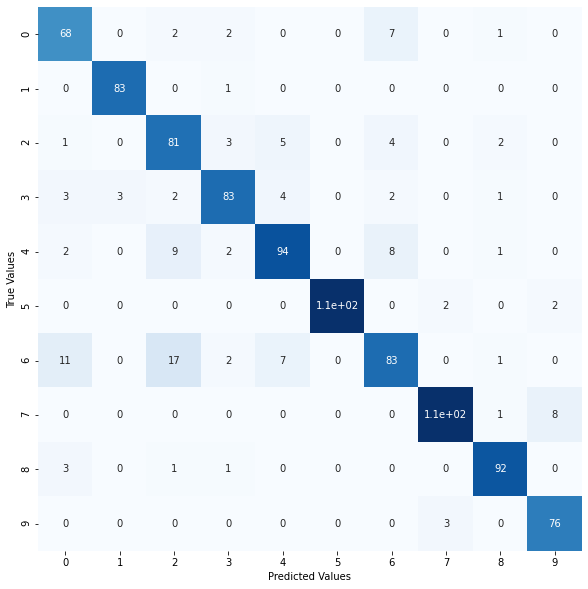

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize=(10, 10))
y_pred = model.predict(x_test)
Y_pred = np.argmax(y_pred, 1)
Y_test = np.argmax(y_test, 1)
mat = confusion_matrix(Y_test, Y_pred)
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

In [15]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81        88
           1       0.99      0.97      0.98        86
           2       0.84      0.72      0.78       112
           3       0.85      0.88      0.86        94
           4       0.81      0.85      0.83       110
           5       0.96      1.00      0.98       108
           6       0.69      0.80      0.74       104
           7       0.92      0.96      0.94       113
           8       0.95      0.93      0.94        99
           9       0.96      0.88      0.92        86

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



#### Dataset con 50% menos en 4 clases

In [0]:
train = pd.read_csv('data_in/fashionmnist/fashion-mnist_test.csv')
test = pd.read_csv('data_in/fashionmnist/fashion-mnist_train.csv')
df = train.copy()
df_test = test.copy()

In [0]:
train = train.drop(train.query('label == 1').sample(frac=.5).index)
train = train.drop(train.query('label == 3').sample(frac=.5).index)
train = train.drop(train.query('label == 5').sample(frac=.5).index)
train = train.drop(train.query('label == 7').sample(frac=.9).index)
train = train.drop(train.query('label == 9').sample(frac=.5).index)

In [18]:
train.label.value_counts()

6    1000
2    1000
8    1000
4    1000
0    1000
3     500
9     500
5     500
1     500
7     100
Name: label, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split

X = train.iloc[:,1:]
Y = train.iloc[:,0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
x_train = x_train.values.reshape((-1, 28, 28, 1))
x_test = x_test.values.reshape((-1, 28, 28, 1))
df_test.drop('label', axis=1, inplace=True)
df_test = df_test.values.reshape((-1, 28, 28, 1))
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
df_test = df_test.astype("float32")/255

from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [0]:
datagen.fit(x_train)

batch_size = 128
epochs = 40
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (x_test, y_test), verbose=0, 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks = [reduce_lr])

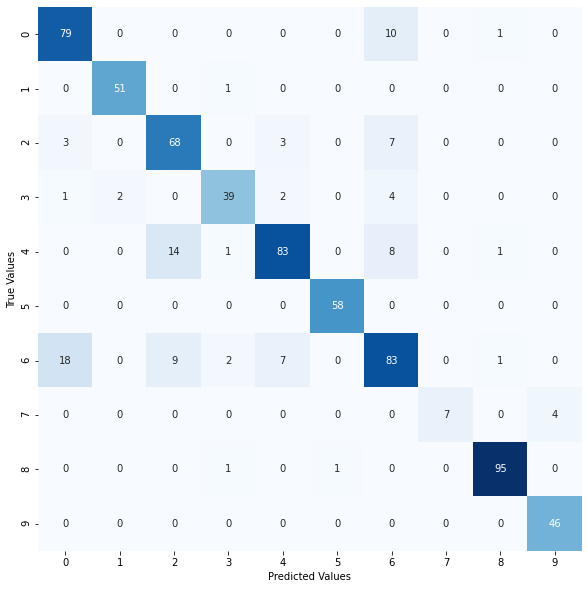

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize=(10, 10))
y_pred = model.predict(x_test)
Y_pred = np.argmax(y_pred, 1)
Y_test = np.argmax(y_test, 1)
mat = confusion_matrix(Y_test, Y_pred)
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

In [22]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       101
           1       0.98      0.96      0.97        53
           2       0.84      0.75      0.79        91
           3       0.81      0.89      0.85        44
           4       0.78      0.87      0.82        95
           5       1.00      0.98      0.99        59
           6       0.69      0.74      0.72       112
           7       0.64      1.00      0.78         7
           8       0.98      0.97      0.97        98
           9       1.00      0.92      0.96        50

    accuracy                           0.86       710
   macro avg       0.86      0.89      0.87       710
weighted avg       0.86      0.86      0.86       710



#### Dataset con 90% menos en 4 clases

In [0]:
train = pd.read_csv('data_in/fashionmnist/fashion-mnist_test.csv')
test = pd.read_csv('data_in/fashionmnist/fashion-mnist_train.csv')
df = train.copy()
df_test = test.copy()

In [0]:
train = train.drop(train.query('label == 1').sample(frac=.9).index)
train = train.drop(train.query('label == 3').sample(frac=.9).index)
train = train.drop(train.query('label == 5').sample(frac=.9).index)
train = train.drop(train.query('label == 7').sample(frac=.9).index)
train = train.drop(train.query('label == 9').sample(frac=.9).index)

In [25]:
train.label.value_counts()

6    1000
2    1000
8    1000
4    1000
0    1000
7     100
3     100
9     100
5     100
1     100
Name: label, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split

X = train.iloc[:,1:]
Y = train.iloc[:,0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
x_train = x_train.values.reshape((-1, 28, 28, 1))
x_test = x_test.values.reshape((-1, 28, 28, 1))
df_test.drop('label', axis=1, inplace=True)
df_test = df_test.values.reshape((-1, 28, 28, 1))
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
df_test = df_test.astype("float32")/255

from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [0]:
datagen.fit(x_train)

batch_size = 128
epochs = 40
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (x_test, y_test), verbose=0, 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks = [reduce_lr])

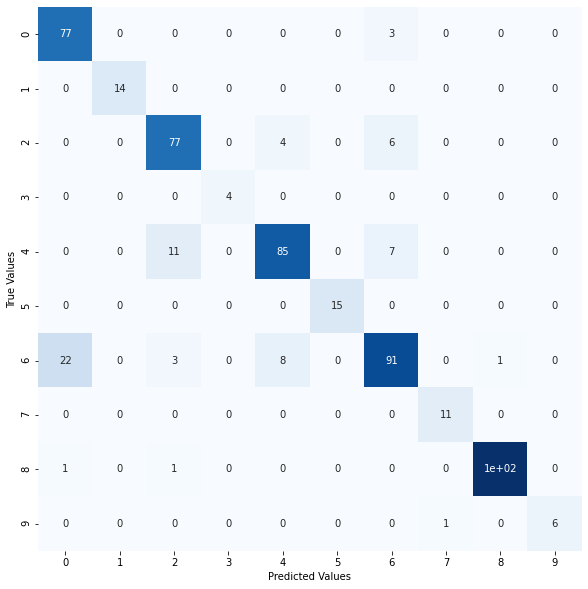

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize=(10, 10))
y_pred = model.predict(x_test)
Y_pred = np.argmax(y_pred, 1)
Y_test = np.argmax(y_test, 1)
mat = confusion_matrix(Y_test, Y_pred)
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

In [29]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.96      0.77      0.86       100
           1       1.00      1.00      1.00        14
           2       0.89      0.84      0.86        92
           3       1.00      1.00      1.00         4
           4       0.83      0.88      0.85        97
           5       1.00      1.00      1.00        15
           6       0.73      0.85      0.78       107
           7       1.00      0.92      0.96        12
           8       0.98      0.99      0.99       103
           9       0.86      1.00      0.92         6

    accuracy                           0.88       550
   macro avg       0.92      0.92      0.92       550
weighted avg       0.89      0.88      0.88       550



### Dataset real - Digit-Recognizer

Este dataset consiste en imagenes de numeros escritos a mano, los cuales están categorizados entre el 0 y el 9.

La red esta basada en el siguiente articulo:
https://www.kaggle.com/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1

In [30]:
! mkdir data_in/digit-recognizer
! kaggle competitions download digit-recognizer -p data_in/digit-recognizer
! unzip data_in/digit-recognizer/train.csv.zip -d data_in/digit-recognizer/
! unzip data_in/digit-recognizer/test.csv.zip -d data_in/digit-recognizer/

 55% 5.00M/9.16M [00:00<00:00, 22.6MB/s]
100% 9.16M/9.16M [00:00<00:00, 30.6MB/s]
 82% 5.00M/6.09M [00:00<00:00, 21.9MB/s]
100% 6.09M/6.09M [00:00<00:00, 23.5MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 213MB/s]
Archive:  data_in/digit-recognizer/train.csv.zip
  inflating: data_in/digit-recognizer/train.csv  
Archive:  data_in/digit-recognizer/test.csv.zip
  inflating: data_in/digit-recognizer/test.csv  


#### Dataset normal

In [0]:
train = pd.read_csv('data_in/digit-recognizer/train.csv')
test = pd.read_csv('data_in/digit-recognizer/test.csv')

In [32]:
train.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [0]:
X = train.drop(['label'], 1).values
y = train['label'].values
test_x = test.values
X = X / 255.0
test_x = test_x / 255.0
X = X.reshape(-1,28,28,1)
test_x = test_x.reshape(-1,28,28,1)
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

In [0]:
model=Sequential()

model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    
model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,activation="relu"))
model.add(Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy",f1])

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)
test_gen = datagen.flow(X_test, y_test, batch_size=batch_size)

batch_size = 64
history = model.fit_generator(train_gen, 
                              epochs = 50,
                              verbose=0,
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              validation_data = test_gen,
                              validation_steps = X_test.shape[0] // batch_size)

In [0]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

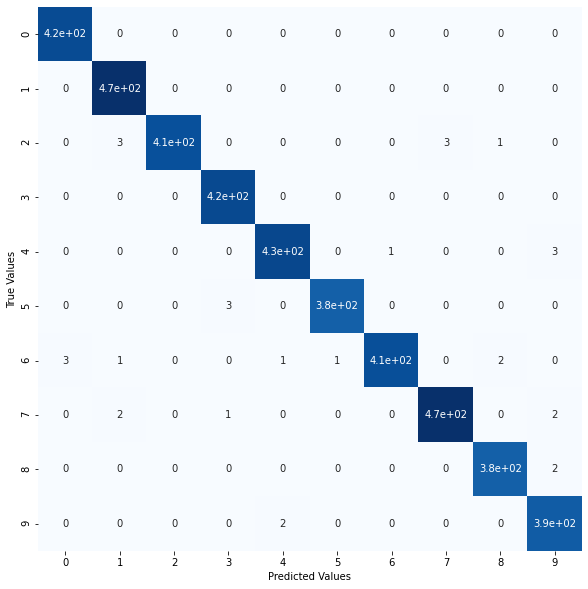

In [37]:
import seaborn as sns

fig = plt.figure(figsize=(10, 10))

y_pred = model.predict(X_test)

Y_pred = np.argmax(y_pred, 1)
Y_test = np.argmax(y_test, 1)

mat = confusion_matrix(Y_test, Y_pred)

sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

In [38]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       422
           1       1.00      0.99      0.99       473
           2       0.98      1.00      0.99       409
           3       1.00      0.99      1.00       426
           4       0.99      0.99      0.99       429
           5       0.99      1.00      0.99       382
           6       0.98      1.00      0.99       412
           7       0.99      0.99      0.99       469
           8       0.99      0.99      0.99       384
           9       0.99      0.98      0.99       394

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



#### Dataset con 50% menos en 4 clases

In [0]:
train = pd.read_csv('data_in/digit-recognizer/train.csv')
test = pd.read_csv('data_in/digit-recognizer/test.csv')

In [0]:
train = train.drop(train.query('label == 1').sample(frac=.5).index)
train = train.drop(train.query('label == 3').sample(frac=.5).index)
train = train.drop(train.query('label == 5').sample(frac=.5).index)
train = train.drop(train.query('label == 7').sample(frac=.9).index)
train = train.drop(train.query('label == 9').sample(frac=.5).index)

In [41]:
train.label.value_counts()

2    4177
6    4137
0    4132
4    4072
8    4063
1    2342
3    2175
9    2094
5    1897
7     440
Name: label, dtype: int64

In [0]:
X = train.drop(['label'], 1).values
y = train['label'].values
test_x = test.values
X = X / 255.0
test_x = test_x / 255.0
X = X.reshape(-1,28,28,1)
test_x = test_x.reshape(-1,28,28,1)
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)
test_gen = datagen.flow(X_test, y_test, batch_size=batch_size)

batch_size = 64
history = model.fit_generator(train_gen, 
                              epochs = 50,
                              verbose=0,
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              validation_data = test_gen,
                              validation_steps = X_test.shape[0] // batch_size)

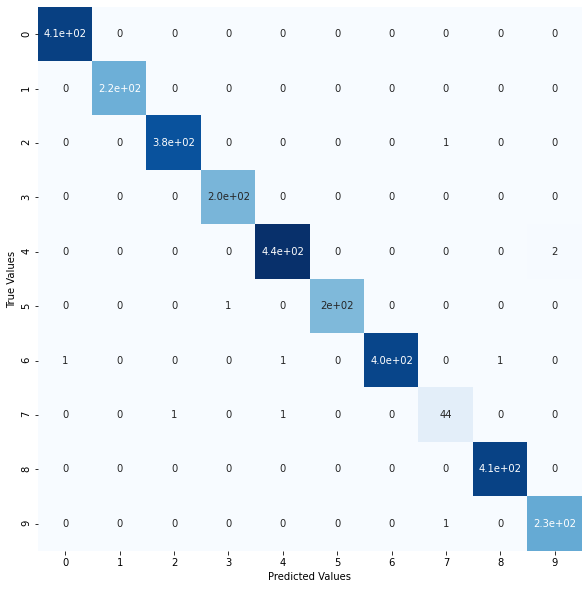

In [44]:
import seaborn as sns

fig = plt.figure(figsize=(10, 10))

y_pred = model.predict(X_test)

Y_pred = np.argmax(y_pred, 1)
Y_test = np.argmax(y_test, 1)

mat = confusion_matrix(Y_test, Y_pred)

sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

In [45]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       414
           1       1.00      1.00      1.00       218
           2       1.00      1.00      1.00       384
           3       1.00      1.00      1.00       206
           4       1.00      1.00      1.00       442
           5       0.99      1.00      1.00       198
           6       0.99      1.00      1.00       405
           7       0.96      0.96      0.96        46
           8       1.00      1.00      1.00       411
           9       1.00      0.99      0.99       229

    accuracy                           1.00      2953
   macro avg       0.99      0.99      0.99      2953
weighted avg       1.00      1.00      1.00      2953



#### Dataset con 90% menos en 4 clases

In [0]:
train = pd.read_csv('data_in/digit-recognizer/train.csv')
test = pd.read_csv('data_in/digit-recognizer/test.csv')

In [0]:
train = train.drop(train.query('label == 1').sample(frac=.9).index)
train = train.drop(train.query('label == 3').sample(frac=.9).index)
train = train.drop(train.query('label == 5').sample(frac=.9).index)
train = train.drop(train.query('label == 7').sample(frac=.9).index)
train = train.drop(train.query('label == 9').sample(frac=.9).index)

In [48]:
train.label.value_counts()

2    4177
6    4137
0    4132
4    4072
8    4063
1     468
7     440
3     435
9     419
5     379
Name: label, dtype: int64

In [0]:
X = train.drop(['label'], 1).values
y = train['label'].values
test_x = test.values
X = X / 255.0
test_x = test_x / 255.0
X = X.reshape(-1,28,28,1)
test_x = test_x.reshape(-1,28,28,1)
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)
test_gen = datagen.flow(X_test, y_test, batch_size=batch_size)

batch_size = 64
history = model.fit_generator(train_gen, 
                              epochs = 50,
                              verbose=0,
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              validation_data = test_gen,
                              validation_steps = X_test.shape[0] // batch_size)

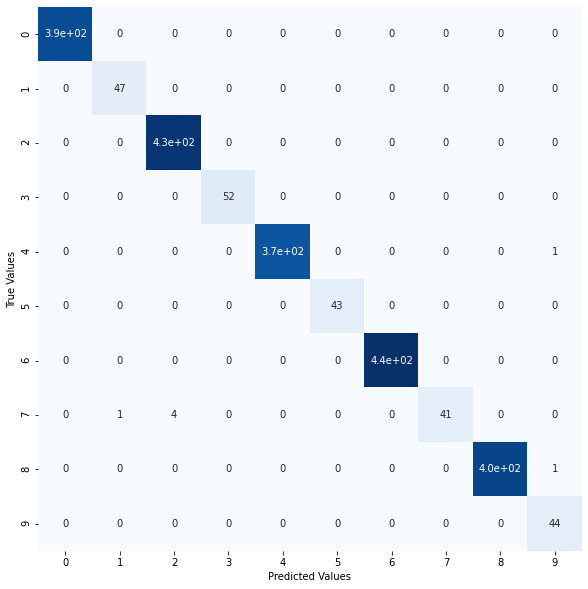

In [51]:
import seaborn as sns

fig = plt.figure(figsize=(10, 10))

y_pred = model.predict(X_test)

Y_pred = np.argmax(y_pred, 1)
Y_test = np.argmax(y_test, 1)

mat = confusion_matrix(Y_test, Y_pred)

sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

In [52]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       391
           1       1.00      0.98      0.99        48
           2       1.00      0.99      1.00       434
           3       1.00      1.00      1.00        52
           4       1.00      1.00      1.00       374
           5       1.00      1.00      1.00        43
           6       1.00      1.00      1.00       439
           7       0.89      1.00      0.94        41
           8       1.00      1.00      1.00       405
           9       1.00      0.96      0.98        46

    accuracy                           1.00      2273
   macro avg       0.99      0.99      0.99      2273
weighted avg       1.00      1.00      1.00      2273



### Dataset sintético

El dataset utilizado es una fabricación a partir de la funcion sklearn.datasets.make_classification, para este caso se utilizaron 4 clases y 100000 datos.

La red esta basada en el siguiente foro:
https://stackoverflow.com/questions/44639940/replicate-mlpclassifier-of-sklearn-in-keras

In [0]:
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def build_fn(optimizer):
    model = Sequential()
    model.add(Dense(200, input_dim=5, kernel_initializer="he_normal", activation="relu"))
    model.add(Dense(100, kernel_initializer="he_normal", activation="relu"))
    model.add(Dense(100, kernel_initializer="he_normal", activation="relu"))
    model.add(Dense(100, kernel_initializer="he_normal", activation="relu"))
    model.add(Dense(4, kernel_initializer="he_normal", activation="softmax"))
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy",f1],
    )
    return model

#### Dataset normal

In [0]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100000, n_features=5, n_classes=4, n_informative=3, random_state=0)

df = pd.concat([pd.DataFrame(X, columns=['feature %d' % (i+1) for i in range(5)]), pd.DataFrame(y, columns=['f'])],axis=1)

In [55]:
df.head()

feature 1  feature 2  feature 3  feature 4  feature 5  f
0  -1.041221  -0.868129   1.476890   1.705858   1.920395  1
1   0.435078   1.627751  -0.179084   0.026276  -2.369945  2
2   1.171515   1.272765  -0.468845   0.260252  -0.880607  2
3   1.755415   1.330900  -1.062981  -0.242849  -0.848549  2
4  -4.274016  -1.433254   1.412294  -1.668433  -2.894442  1

In [56]:
df.f.value_counts()

0    25019
3    25013
2    25006
1    24962
Name: f, dtype: int64

In [0]:
X = np.asarray(df[['feature 1','feature 2','feature 3','feature 4','feature 5']])
y = np.asarray(df['f'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [0]:
clf = KerasClassifier(build_fn, optimizer="rmsprop", epochs=500, batch_size=300)

In [0]:
history = clf.fit(X_train, y_train, verbose=0, validation_split=0.4)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


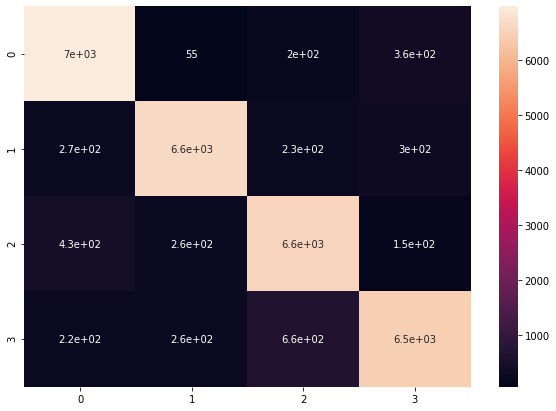

In [60]:
from seaborn import  heatmap
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)

confusion_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(confusion_matrix)
plt.figure(figsize = (10,7))
heatmap(df_cm, annot=True)
plt.show()

In [61]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      7586
           1       0.92      0.89      0.91      7428
           2       0.86      0.89      0.87      7399
           3       0.89      0.85      0.87      7587

    accuracy                           0.89     30000
   macro avg       0.89      0.89      0.89     30000
weighted avg       0.89      0.89      0.89     30000



#### Dataset con 50% menos en 2 clases

In [0]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100000, n_features=5, n_classes=4, n_informative=3, random_state=0)

df = pd.concat([pd.DataFrame(X, columns=['feature %d' % (i+1) for i in range(5)]), pd.DataFrame(y, columns=['f'])],axis=1)

In [0]:
df = df.drop(df.query('f == 0').sample(frac=.5).index)
df = df.drop(df.query('f == 2').sample(frac=.5).index)

In [64]:
df.f.value_counts()

3    25013
1    24962
0    12509
2    12503
Name: f, dtype: int64

In [0]:
X = np.asarray(df[['feature 1','feature 2','feature 3','feature 4','feature 5']])
y = np.asarray(df['f'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [0]:
clf = KerasClassifier(build_fn, optimizer="rmsprop", epochs=500, batch_size=300)

In [0]:
history = clf.fit(X_train, y_train, verbose=0, validation_split=0.4)

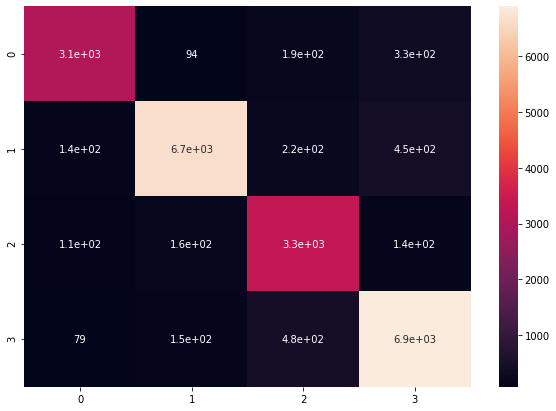

In [68]:
from seaborn import  heatmap
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)

confusion_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(confusion_matrix)
plt.figure(figsize = (10,7))
heatmap(df_cm, annot=True)
plt.show()

In [69]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.83      0.87      3667
           1       0.94      0.89      0.92      7478
           2       0.79      0.89      0.84      3761
           3       0.88      0.91      0.89      7591

    accuracy                           0.89     22497
   macro avg       0.88      0.88      0.88     22497
weighted avg       0.89      0.89      0.89     22497



#### Dataset con 90% menos en 2 clases

In [0]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100000, n_features=5, n_classes=4, n_informative=3, random_state=0)

df = pd.concat([pd.DataFrame(X, columns=['feature %d' % (i+1) for i in range(5)]), pd.DataFrame(y, columns=['f'])],axis=1)

In [0]:
df = df.drop(df.query('f == 0').sample(frac=.9).index)
df = df.drop(df.query('f == 2').sample(frac=.9).index)

In [72]:
df.f.value_counts()

3    25013
1    24962
0     2502
2     2501
Name: f, dtype: int64

In [0]:
X = np.asarray(df[['feature 1','feature 2','feature 3','feature 4','feature 5']])
y = np.asarray(df['f'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [0]:
clf = KerasClassifier(build_fn, optimizer="rmsprop", epochs=500, batch_size=300)

In [0]:
history = clf.fit(X_train, y_train, verbose=0, validation_split=0.4)

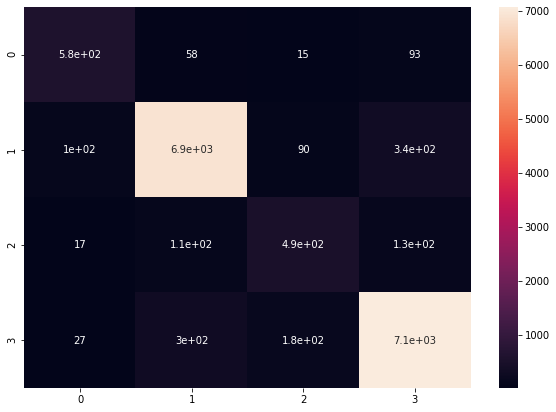

In [76]:
from seaborn import  heatmap
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)

confusion_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(confusion_matrix)
plt.figure(figsize = (10,7))
heatmap(df_cm, annot=True)
plt.show()

In [77]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       744
           1       0.94      0.93      0.93      7437
           2       0.63      0.65      0.64       746
           3       0.93      0.93      0.93      7567

    accuracy                           0.91     16494
   macro avg       0.82      0.82      0.82     16494
weighted avg       0.91      0.91      0.91     16494



# Challenge Kaggle

https://www.kaggle.com/c/taller1ann-usm

## Descargar dataset

In [78]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
main_path = "/content/drive/My Drive/ann/taller1/" 

## Datos iniciales

Comenzamos cargando los path de los archivos:

In [0]:
train_path = main_path + 'train_images/'
train_labels_path = main_path + 'train_labels.csv'
valid_path = main_path + 'test_images/'
sample_submission_path = main_path + 'sample_submission.csv'
submission_last = 'submission_last.csv'

A continuación sacamos el nombre de las clases y la cantidad :

In [0]:
df = pd.read_csv(train_labels_path)
bd = dict(df.Expected.value_counts())
class_names = list(bd.keys())
num_class = len(class_names)

Procedemos a sacar el shape de la imagen. Si bien este lo dan en el enunciado, queremos estar seguro de que la implementación funcione en otros casos.

In [0]:
img = plt.imread(train_path + df.iloc[0]['Id']+'.jpg')
shape_img = img.shape

Ahora hagamos un pequeño plot de al menos 5 images por cada clase:

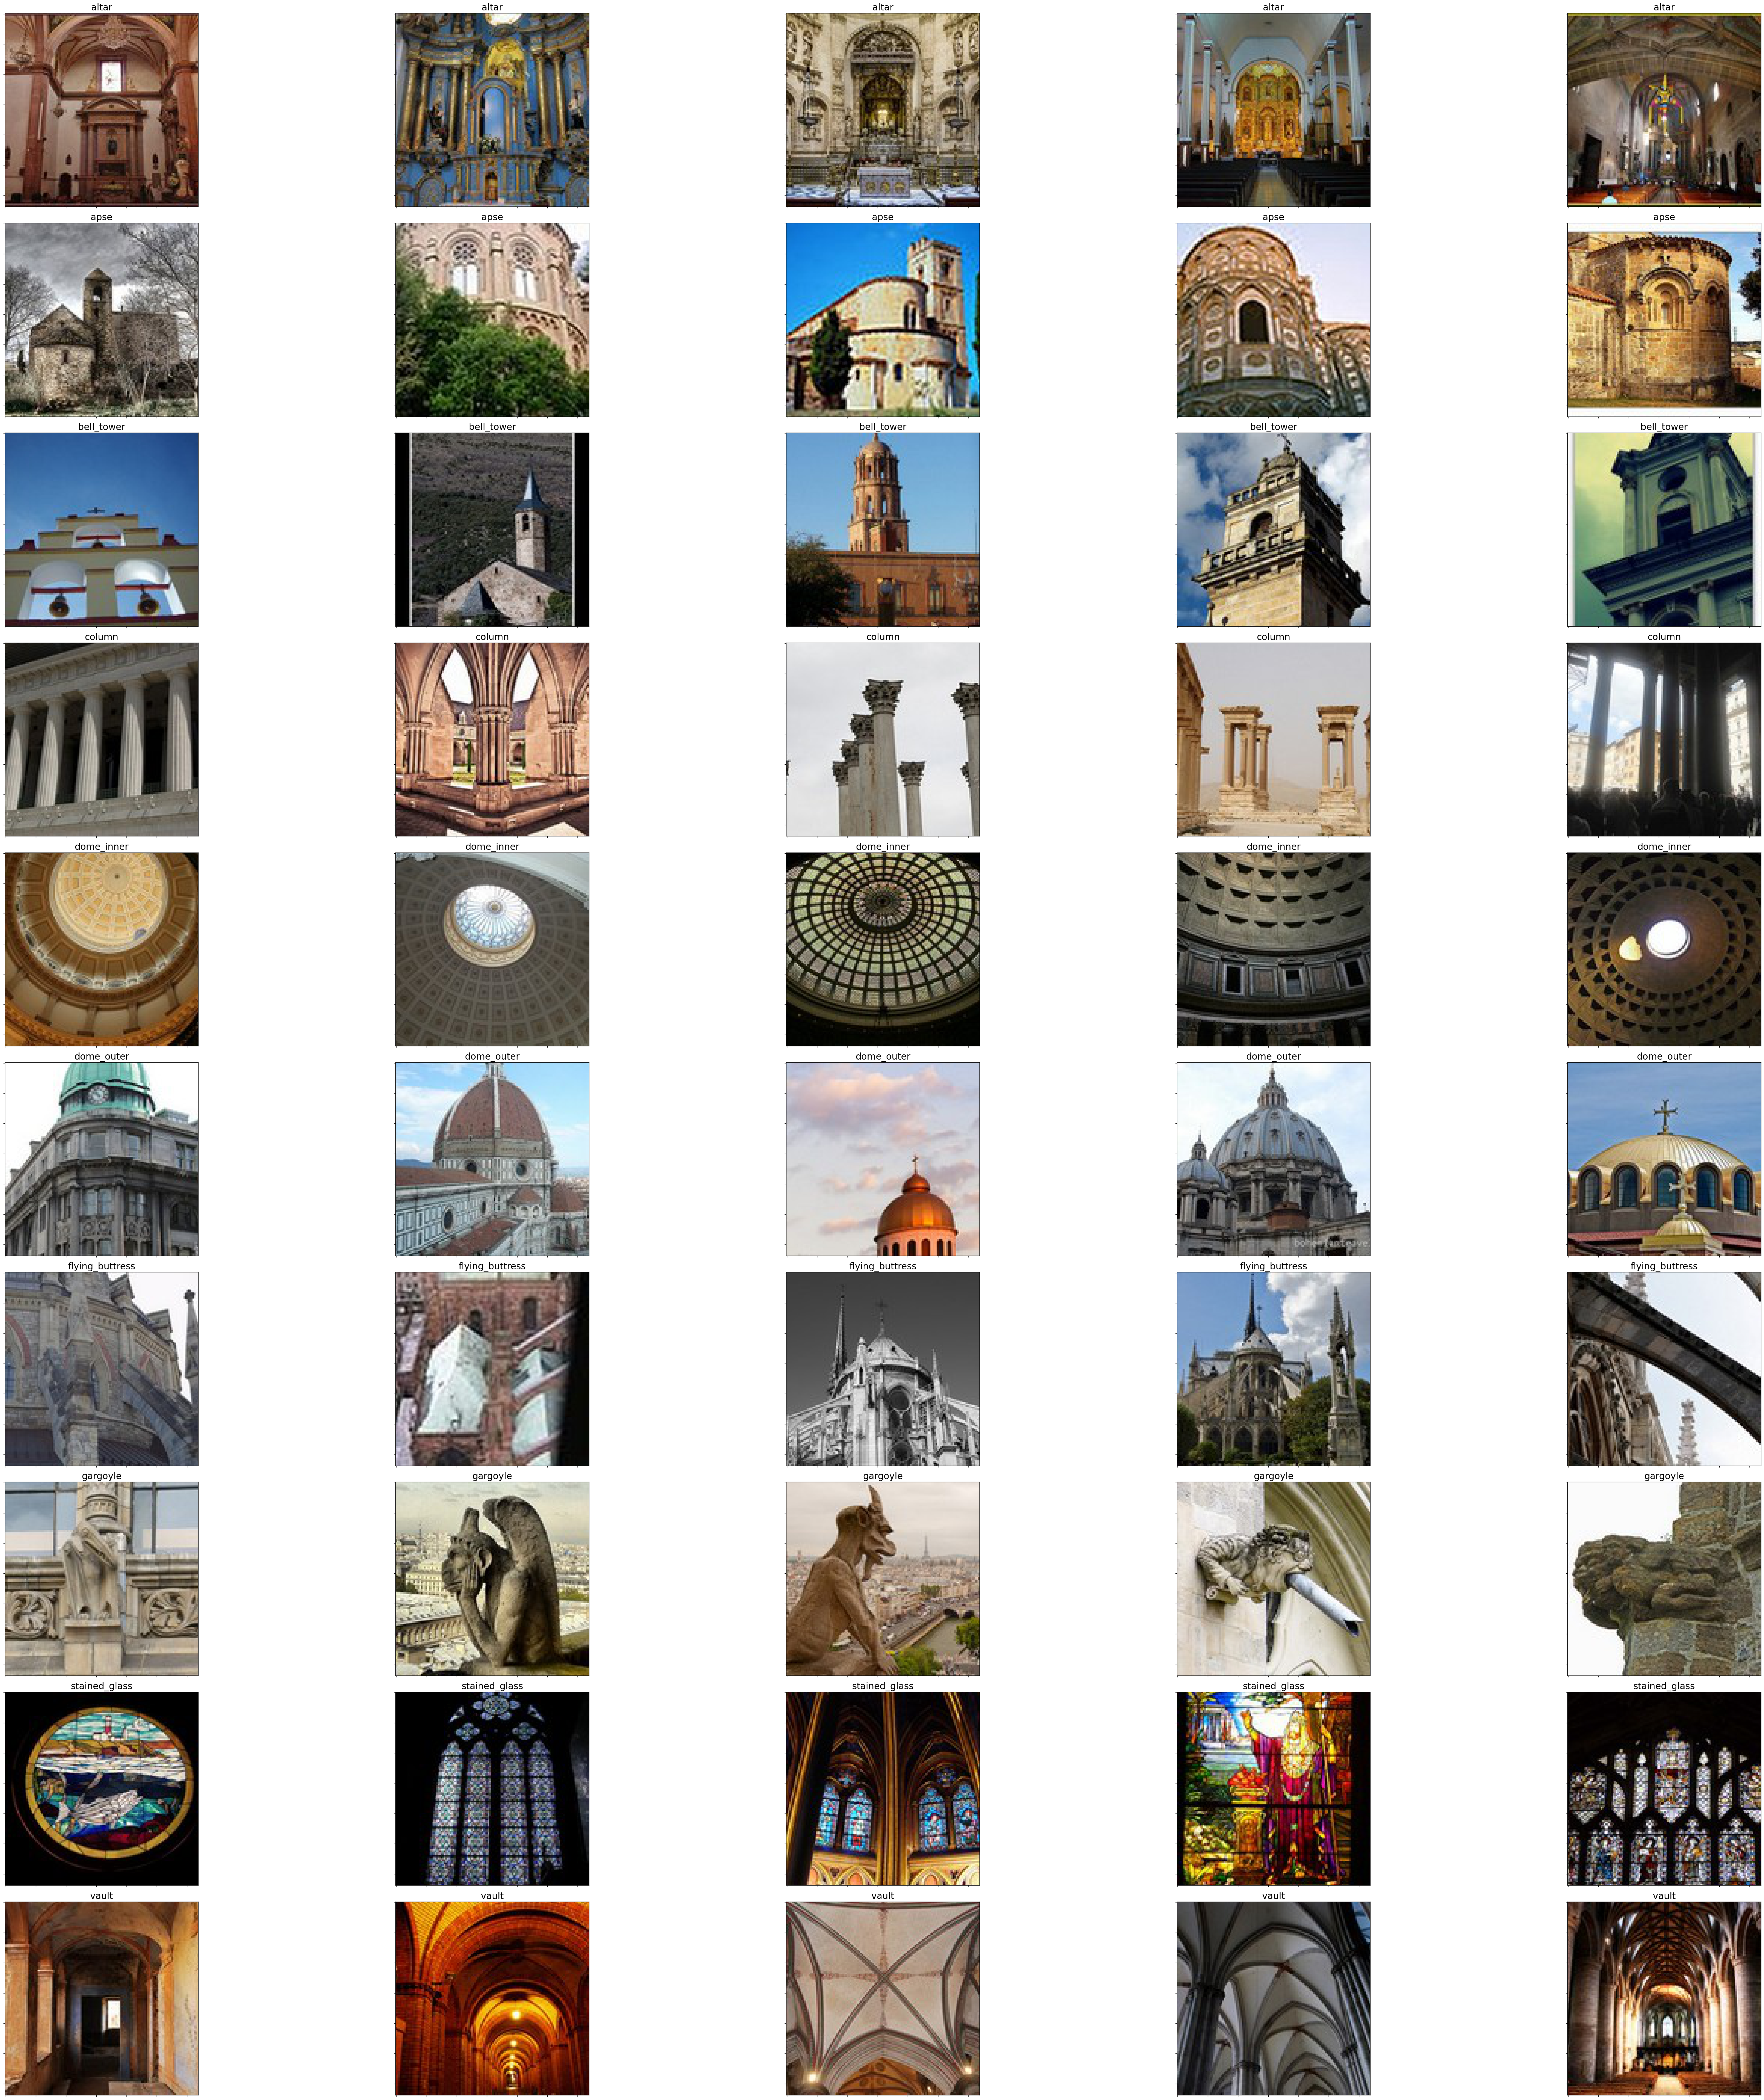

In [83]:
df_q = pd.read_csv(train_labels_path)
df_q.columns = ['image', 'label']
dict_classes_img = df_q.groupby(['label'])['image'].apply(list).to_dict()

fig, axs = plt.subplots(num_class, 5, figsize=(64,64), dpi=120)
i=0
for label, imgs in dict_classes_img.items():
  for j in range(5):
    imgplot = plt.imread(train_path + imgs[j] + '.jpg')
    axs[i, j].imshow(imgplot)
    axs[i, j].set_title(label, fontsize=20)
    axs[i, j].set_yticklabels([])
    axs[i, j].set_xticklabels([])
  i+=1
plt.tight_layout()
plt.show()

Lo que sigue es crear el dataframe con los datos para el proceso de entrenamiento y validación:

In [0]:
labels = pd.read_csv(train_labels_path).set_index('Id')
labels = labels.to_dict()
labels = labels[list(labels.keys())[0]]

df = pd.DataFrame(list(labels.items()))
df.columns = ['images', 'labels']
df = df.astype({'labels': str})
df['images'] = df['images'].map(lambda s: s+'.jpg')

Luego hacemos un clásico split para los datos de validación y entremiento. En este caso será 30% validación y 70% entrenamiento:

In [85]:
from sklearn.model_selection import train_test_split

train_df, validation_df = train_test_split(df, test_size=0.3)

print(f'train_df: {train_df.shape}')
print(f'validation_df: {validation_df.shape}')

train_df: (6448, 2)
validation_df: (2764, 2)


## Modelo

Comenzamos con el procesamiento de las imagenes. Para ello, utilizaremos el `generator` que trae keras, y la función de preprocesamiento será la que viene en el modelo pre entrenado a utlizar.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import inception_resnet_v2

datagen = ImageDataGenerator(
    horizontal_flip=True, 
    validation_split=0.2, 
    preprocessing_function=inception_resnet_v2.preprocess_input)

Aplicamos el `datagen` sobre nuestras imagenes de entrenamiento y validacion:

In [87]:
 train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=train_path,
        x_col="images",
        y_col="labels",
        target_size=shape_img[:-1],
        batch_size=32,
        class_mode='categorical')

validation_generator = datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory=train_path,
        x_col="images",
        y_col="labels",
        target_size=shape_img[:-1],
        batch_size=32,
        class_mode='categorical')

Found 6448 validated image filenames belonging to 10 classes.
Found 2764 validated image filenames belonging to 10 classes.


Esta es la parte más importante, dado que procederemos a crear nuestro modelo.

En este caso usaremos como base un modelo pre-entrenado que será `InceptionResNetV2`, los pesos serán los del dataset `imagenet`, el cual cuenta con 10.000 clases de imágenes. Deshabilitaremos la última capa del modelo pre-entrenado dado que crearemos nuestra propia capa para las $n$ clases que deseamos clasificar. 

In [88]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras.models import Model

base_model = inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=shape_img)

x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model_resnet_v2_inception = Model(inputs=base_model.input, outputs = predictions)

219062272/219055592 [==============================] - 7s 0us/step


La siguiente parte es para el FineTunning, pero esta deshabilitada dado que no nos trajo mejores resultados.

In [0]:
#LAYERS_TO_FREEZE=700
#for layer in base_model.layers[:LAYERS_TO_FREEZE]:
#    layer.trainable = False

Ahora pasamos a compilar nuestra red. Como optimizador utilizaremos `Adam`. Y la función loss a utlizar será `categorical_crossentropy` dado que se trata de multiples clases.

In [0]:
from keras.optimizers import Adam
model_resnet_v2_inception.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=[f1,'accuracy'])

A continuación definimos los callback para nuestra red. Los callback que vamos a usar son `EarlyStopping`, para que el entrenamiento pare si ve que no mejora la función de coste tras determinados epochs, y `ReduceLROnPlateau` la cual hace que si el entrenamiento no mejora tras unos epochs específicos, reduzca el valor de learning rate del modelo.

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]

## Entrenamiento

Finalmente hacemos el entrenamiento:

In [92]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

model_history = model_resnet_v2_inception.fit_generator(
                train_generator,
                steps_per_epoch=STEP_SIZE_TRAIN,
                epochs=50,
                validation_data=validation_generator,
                validation_steps=STEP_SIZE_VALID,
                callbacks=callbacks_list)

Epoch 1/50
201/201 [==============================] - 3421s 17s/step - loss: 0.7687 - f1: 0.7689 - accuracy: 0.7788 - val_loss: 2.4685 - val_f1: 0.6795 - val_accuracy: 0.7020
Epoch 2/50
201/201 [==============================] - 80s 397ms/step - loss: 0.3915 - f1: 0.8841 - accuracy: 0.8858 - val_loss: 0.7556 - val_f1: 0.7297 - val_accuracy: 0.7284
Epoch 3/50
201/201 [==============================] - 78s 389ms/step - loss: 0.3540 - f1: 0.8972 - accuracy: 0.8982 - val_loss: 0.4294 - val_f1: 0.8656 - val_accuracy: 0.8638
Epoch 4/50
201/201 [==============================] - 78s 388ms/step - loss: 0.2807 - f1: 0.9186 - accuracy: 0.9188 - val_loss: 0.7346 - val_f1: 0.8142 - val_accuracy: 0.8104
Epoch 5/50
201/201 [==============================] - 78s 387ms/step - loss: 0.2088 - f1: 0.9387 - accuracy: 0.9387 - val_loss: 0.3578 - val_f1: 0.9022 - val_accuracy: 0.8990
Epoch 6/50
201/201 [==============================] - 78s 386ms/step - loss: 0.1766 - f1: 0.9488 - accuracy: 0.9484 - val_los

Ahora podemos ver como se comportó nuestro entremiento, viendo los gráficos de la F1, del accuracy y la loss:

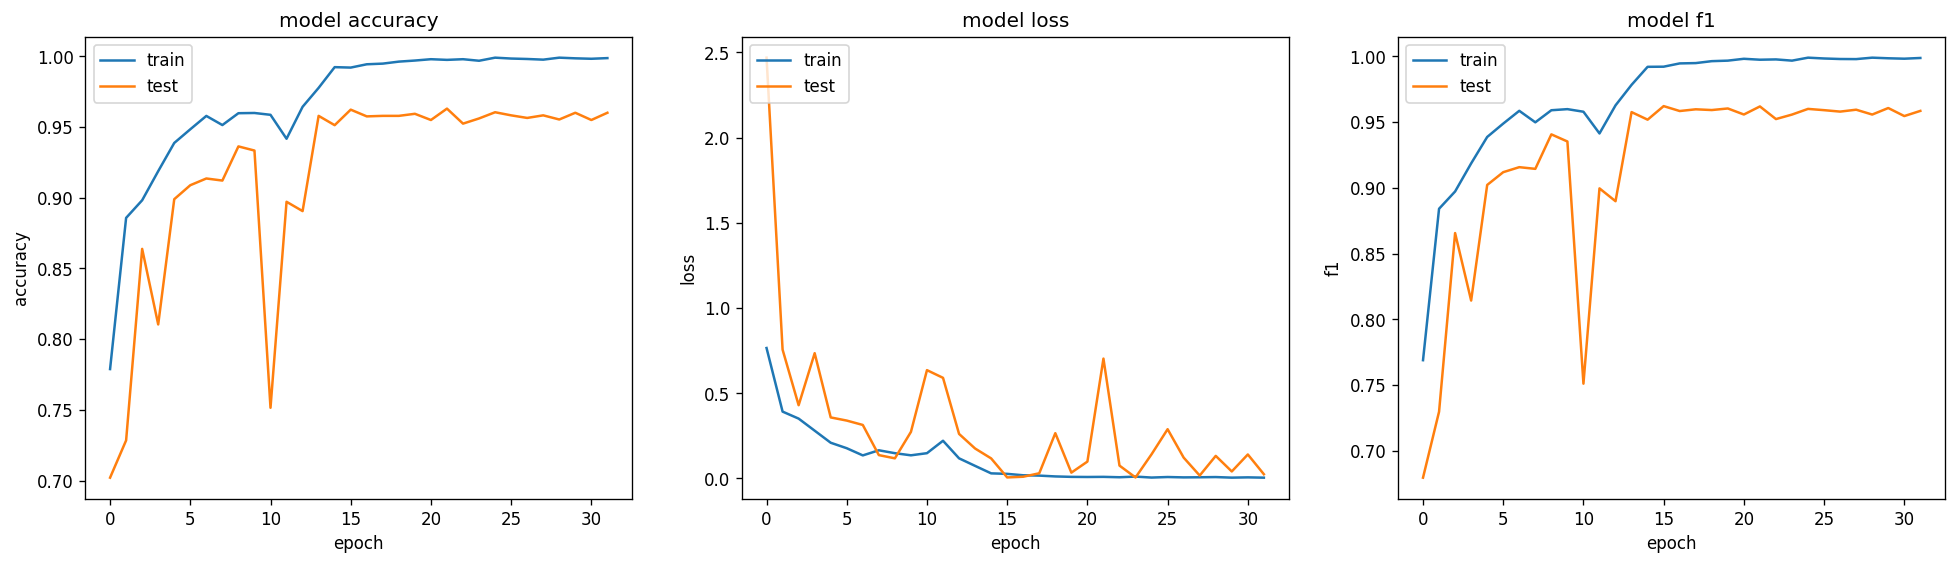

In [93]:
from matplotlib import pyplot as plt

plt.rcdefaults()
fig, axs = plt.subplots(1,3, figsize=(20,5), dpi=120)

metrics = [('accuracy','val_accuracy'), ('loss','val_loss'), ('f1','val_f1')]

for ite, pac in enumerate(metrics):
  axs[ite].plot(model_history.history[pac[0]])
  axs[ite].plot(model_history.history[pac[1]])
  axs[ite].set_xlabel('epoch')
  axs[ite].set_ylabel(pac[0])
  axs[ite].set_title('model %s' % pac[0])
  axs[ite].legend(['train', 'test'], loc='upper left')

plt.show()

Por si las dudas, guardamos el modelo descomentado esta linea:

In [0]:
#model_resnet_v2_inception.save("ann_taller1_resnet_v2_inception.h5")

## Predicción y submission

Ahora debemos preparar la predicción para las imagenes del submission de la competencia.

In [95]:
df_test = pd.read_csv(sample_submission_path).set_index('Id').to_dict()
df_test = df_test[list(df_test.keys())[0]]
df_test = pd.DataFrame(list(df_test.items()))
df_test.columns = ['images', 'expected']
df_test['images'] = df_test['images'].map(lambda s: s+'.jpg')

test_generator = datagen.flow_from_directory(
        valid_path,
        target_size=shape_img[:-1],
        shuffle = False,
        class_mode=None,
        batch_size=1)

filenames = [filename for filename in test_generator.filenames]
nb_samples = len(filenames)

Found 1023 images belonging to 1 classes.


Comenzamos la parte más importante que es la predicción de las imágenes:

In [96]:
predictions = model_resnet_v2_inception.predict_generator(test_generator,steps = nb_samples, verbose=1)

1023/1023 [==============================] - 397s 388ms/step


Terminamos creando el `.csv` con los `labels` predichos y los empaquetamos para el submit:

In [0]:
y_pred_labels = np.argmax(predictions, axis = 1)


labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions_label = [labels[k] for k in y_pred_labels]
filenames_label = [s[12:-4] for s in filenames]


submission = pd.DataFrame({'Id':filenames_label,'Expected':predictions_label})
submission.to_csv(submission_last, index=False, header=True)

# Referencias
* https://www.researchgate.net/publication/339827022_CNN_Classification_of_the_Cultural_Heritage_Images
* https://www.researchgate.net/publication/320052364_Classification_of_Architectural_Heritage_Images_Using_Deep_Learning_Techniques
* https://old.datahub.io/dataset/architectural-heritage-elements-image-dataset